In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting

In [2]:
tickers = ['BSX','AES','BRK-B','SEE','QQQ','SPY']
thelen = len(tickers)
price_data = []
for ticker in range(thelen):
    prices = web.DataReader(tickers[ticker], start='2015-01-01', end = '2020-06-06', data_source='yahoo')
    price_data.append(prices.assign(ticker=ticker)[['Adj Close']])
df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers
#Annualized Return
mu = expected_returns.mean_historical_return(df_stocks)
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)

In [5]:
from pypfopt import objective_functions 

def l2_reg(self, target_volatility, market_neutral=False):
        """
        Minimize the L2 norm under target-volatility bound. The resulting portfolio will have a volatility
        less than the target (but not guaranteed to be equal).

        :param target_volatility: the desired maximum volatility of the resulting portfolio.
        :type target_volatility: float
        :param market_neutral: whether the portfolio should be market neutral (weights sum to zero),
                               defaults to False. Requires negative lower weight bound.
        :param market_neutral: bool, optional
        :raises ValueError: if ``target_volatility`` is not a positive float
        :raises ValueError: if no portfolio can be found with volatility equal to ``target_volatility``
        :raises ValueError: if ``risk_free_rate`` is non-numeric
        :return: asset weights for the efficient risk portfolio
        :rtype: OrderedDict
        """
        if not isinstance(target_volatility, (float, int)) or target_volatility < 0:
            raise ValueError("target_volatility should be a positive float")

        global_min_volatility = np.sqrt(1 / np.sum(np.linalg.inv(self.cov_matrix)))

        if target_volatility < global_min_volatility:
            raise ValueError(
                "The minimum volatility is {:.3f}. Please use a higher target_volatility".format(
                    global_min_volatility
                )
            )

        self._objective = objective_functions.L2_reg(w=self._w, gamma=1
        )
        variance = objective_functions.portfolio_variance(self._w, self.cov_matrix)

        for obj in self._additional_objectives:
            self._objective += obj

        self._constraints.append(variance <= target_volatility ** 2)
        self._make_weight_sum_constraint(market_neutral)
        return self._solve_cvxpy_opt_problem()

# Add the custom optimization problem
EfficientFrontier.l2_reg = l2_reg

0.16730539919999998 L2 Norm
0.2000000000016413


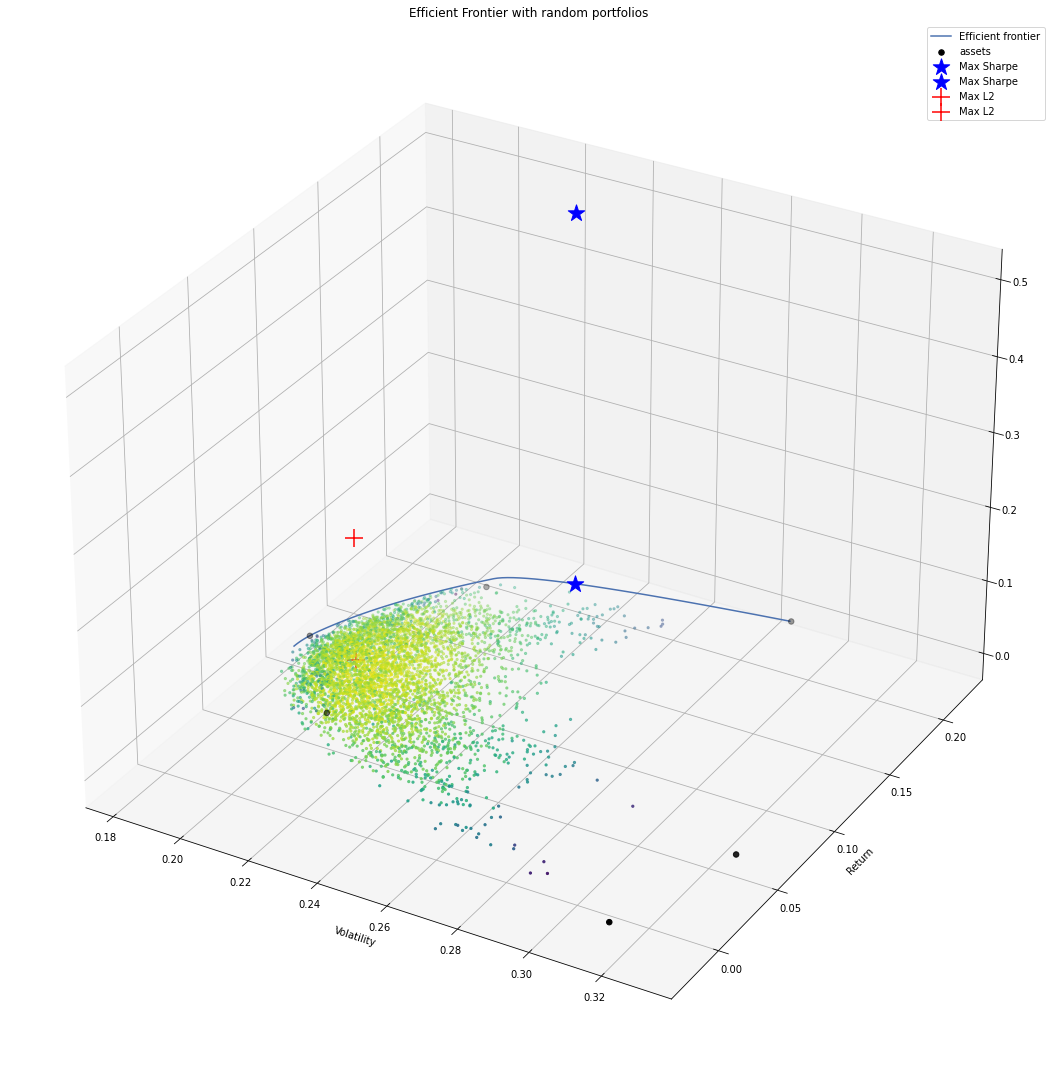

In [8]:
fig = plt.figure(figsize=(15, 15))
ax= fig.add_subplot(projection='3d')
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Generate random portfolios
n_samples = 5000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ Sigma @ w.T))
l_2 = [wx.T@wx for wx in w]
sharpes = rets / stds
ax.scatter3D(stds, rets, 0, marker=".", c=l_2, cmap="viridis_r")

# Find the tangency portfolio
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) 
ef.max_sharpe(risk_free_rate=0.1)
ret_tangent, std_tangent, _ = ef.portfolio_performance()
sharpe_pwt=np.array(list(ef.clean_weights().values()))
ax.scatter3D(std_tangent, ret_tangent,(sharpe_pwt.T@sharpe_pwt), s=300, marker="*", c="b", label="Max Sharpe")
ax.scatter3D(std_tangent, ret_tangent, 0, s=300, marker="*", c="b", label="Max Sharpe")

# # Find the L2 portfolio
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
ef.l2_reg(target_volatility=0.2) 
ret_tangent, std_tangent, _ = ef.portfolio_performance()
l_2_wt = np.array(list(ef.clean_weights().values()))
ax.scatter3D(std_tangent, ret_tangent, (l_2_wt.T@l_2_wt), s=300, marker="+", c="r", label="Max L2")
ax.scatter3D(std_tangent, ret_tangent,  0, s=300, marker="+", c="r", label="Max L2")
print(f'{(l_2_wt.T@l_2_wt)} L2 Norm')
print(std_tangent)

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()

plt.tight_layout()
plt.savefig("ef.png", dpi=200)
plt.show()